In [190]:
import pandas as pd
import numpy as np
import re
from typing import Optional
import seaborn as sns
import matplotlib.pyplot as plt
import os

PHẦN 1: CẤU HÌNH

In [191]:
# --- File paths ---
INPUT_FILE = '../../data/merge/All-Merge-Raw.csv'
OUTPUT_FILE = '../../data/cleaned/Done-pre.csv'

In [192]:
# --- Ngưỡng lọc dữ liệu ---
MIN_PRICE = 0.5        # Tỷ VND
MAX_PRICE = 500        # Tỷ VND
MIN_AREA = 10          # m2
MAX_AREA = 1000        # m2
MIN_WIDTH = 1.5        # m
MAX_WIDTH = 50         # m
MAX_FLOORS = 10

In [193]:
# --- Các cột quan trọng (không được thiếu) ---
CRITICAL_COLUMNS = ['Price_Per_m2', 'District', 'Width_m', 'Area_m2']

In [194]:
# --- Từ điển phường xã TP.HCM ---
HCM_WARDS = {
    'Quận 1': ['Bến Nghé', 'Bến Thành', 'Cô Giang', 'Cầu Kho', 'Cầu Ông Lãnh',
               'Đa Kao', 'Nguyễn Cư Trinh', 'Nguyễn Thái Bình', 'Phạm Ngũ Lão', 'Tân Định'],
    'Quận 3': ['1', '2', '3', '4', '5', '9', '10', '11', '12', '14', 'Võ Thị Sáu', '6', '7', '8'],
    'Quận 4': ['1', '2', '3', '4', '6', '8', '9', '10', '13', '14', '15', '16', '18', '12'],
    'Quận 5': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15'],
    'Quận 6': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14'],
    'Quận 7': ['Bình Thuận', 'Phú Mỹ', 'Phú Thuận', 'Tân Hưng', 'Tân Kiểng',
               'Tân Phong', 'Tân Phú', 'Tân Quy', 'Tân Thuận Đông', 'Tân Thuận Tây'],
    'Quận 8': ['1', '2', '3', '4', '5', '6', '8', '7', '9', '10', '11', '12', '13', '14', '15', '16'],
    'Quận 10': ['1', '2', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '3'],
    'Quận 11': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'],
    'Quận 12': ['An Phú Đông', 'Đông Hưng Thuận', 'Hiệp Thành', 'Tân Chánh Hiệp',
                'Tân Hưng Thuận', 'Tân Thới Hiệp', 'Tân Thới Nhất', 'Thạnh Lộc',
                'Thạnh Xuân', 'Thới An', 'Trung Mỹ Tây'],
    'Bình Thạnh': ['1', '2', '3', '5', '6', '7', '11', '12', '13', '14', '15',
                   '17', '19', '21', '22', '24', '25', '26', '27', '28'],
    'Gò Vấp': ['1', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17'],
    'Phú Nhuận': ['1', '2', '3', '4', '5', '7', '8', '9', '10', '11', '13', '15', '17'],
    'Tân Bình': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15'],
    'Tân Phú': ['Hiệp Tân', 'Hòa Thạnh', 'Phú Thọ Hòa', 'Phú Thạnh', 'Phú Trung',
                'Sơn Kỳ', 'Tân Quý', 'Tân Sơn Nhì', 'Tân Thành', 'Tân Thới Hòa', 'Tây Thạnh'],
    'Bình Tân': ['An Lạc', 'An Lạc A', 'Bình Hưng Hòa', 'Bình Hưng Hòa A',
                 'Bình Hưng Hòa B', 'Bình Trị Đông', 'Bình Trị Đông A',
                 'Bình Trị Đông B', 'Tân Tạo', 'Tân Tạo A'],
    'Thủ Đức': ['Bình Chiểu', 'Bình Thọ', 'Hiệp Bình Chánh', 'Hiệp Bình Phước',
                'Linh Chiểu', 'Linh Đông', 'Linh Tây', 'Linh Trung', 'Linh Xuân',
                'Tam Bình', 'Tam Phú', 'Trường Thọ'],
}

In [195]:
# --- Mapping phường sáp nhập ---
MERGED_WARD_MAPPING = {
    ('Gò Vấp', 'Hạnh Thông'): '1',
    ('Quận 3', 'Võ Thị Sáu'): '6',
    ('Quận 4', '12'): '13',
    ('Quận 5', '15'): '12',
    ('Quận 10', '3'): '2',
}

PHẦN 2: CÁC HÀM TRÍCH XUẤT ĐẶC TRƯNG

1. Tạo feature Width_m,Is_Mattien, Width_m

Hàm lấy width

In [196]:
# --- 1. Hàm trích xuất Chiều ngang (Width) ---
def extract_width(row: pd.Series) -> Optional[float]:
    """
    Trích xuất chiều ngang (Width) từ Title và Description

    Các mẫu tìm kiếm:
    - "Chiều rộng 7.7m"
    - "Ngang 5m"
    - "4x16" (dạng AxB)
    """
    text = str(row.get('Description', '')) + " " + str(row.get('Title', ''))
    text = text.lower()
    text = text.replace(',', '.')
    text = re.sub(r'[❌*×]', 'x', text)
    text = re.sub(r'[–\-_:]', ' ', text)

    # Mẫu 1: "Chiều rộng X"
    match = re.search(r'chiều\s*rộng\s*(\d+[.]?\d*)', text)
    if match:
        try:
            val = float(match.group(1))
            if val > 50: val = val / 10  # Fix lỗi typo
            if 0 < val < 50: return val
        except: pass

    # Mẫu 2: "Ngang/Rộng/MT"
    match = re.search(r'(?:ngang|rộng|mt)(?:.{0,15}?)\s+(\d+[.]?\d*)', text)
    if match:
        try:
            val = float(match.group(1))
            if 0 < val < 50: return val
        except: pass

    # Mẫu 3: AxB
    matches = list(re.finditer(r'(\d+[.]?\d*)\s*m?\s*x\s*(\d+[.]?\d*)', text))
    if matches:
        for m in matches:
            try:
                n1 = float(m.group(1))
                n2 = float(m.group(2))
                width = min(n1, n2)
                if 'm' in m.group(0) and 2 <= width < 50:
                    return width
                if 2 <= width < 50:
                    temp_width = width
            except: continue
        if 'temp_width' in locals(): return temp_width

    return None

Hàm check mặt tiền

In [197]:
# --- 2. Hàm xác định Mặt tiền (Is_MatTien) ---
def check_mattien(row: pd.Series) -> int:
    """
    Xác định nhà có mặt tiền hay không

    Returns:
        1: Có mặt tiền
        0: Nhà hẻm
    """
    text = str(row['Title']) + " " + str(row['Description'])
    text = text.lower()

    # Loại trừ
    exclude_keywords = ['sát mặt tiền', 'cách mặt tiền', 'gần mặt tiền', 'sau mặt tiền']
    for kw in exclude_keywords:
        if kw in text:
            return 0

    # Khẳng định
    positive_keywords = ['mặt tiền', 'mtkd', 'mt đường', 'lô góc', '2 mặt tiền']
    for kw in positive_keywords:
        if kw in text:
            return 1

    return 0


Hàm tính giá trên m2

In [198]:
def calculate_price_per_m2(row: pd.Series) -> float:
    """
    Tính đơn giá (triệu/m2)
    """
    price = row.get('Price_Billion', 0)
    area = row.get('Area_m2', 0)

    if pd.notnull(area) and area > 1:
        return round((price * 1000) / area, 2)
    return 0

3. Dựa kết quả lọc width tìm lại trường Area_m2 bị trống, tính lại số tiền trên mỗi m2

Hàm phục hồi dữ liệu diện tích thiếu

In [199]:
# --- 3. Hàm phục hồi diện tích bị mất ---
def recover_missing_area(row: pd.Series) -> Optional[float]:
    """
    Phục hồi diện tích thiếu bằng cách tính Width x Length
    """
    current_area = row.get('Area_m2', 0)
    if pd.notnull(current_area) and current_area > 0:
        return current_area

    width = row.get('Width_m')
    if pd.isnull(width) or width == 0:
        return current_area

    text = str(row.get('Description', '')) + " " + str(row.get('Title', ''))
    text = text.lower()
    text = text.replace(',', '.')
    text = re.sub(r'[❌*×]', 'x', text)
    text = re.sub(r'[–\-_:]', ' ', text)

    length = None

    # Tìm "Dài X"
    match_dai = re.search(r'dài\s*(\d+[.]?\d*)', text)
    if match_dai:
        try:
            val = float(match_dai.group(1))
            if val >= width and val < 150:
                length = val
        except: pass

    # Tìm trong AxB
    if length is None:
        matches = list(re.finditer(r'(\d+[.]?\d*)\s*m?\s*x\s*(\d+[.]?\d*)', text))
        for m in matches:
            try:
                n1 = float(m.group(1))
                n2 = float(m.group(2))
                if abs(n1 - width) < 0.1: length = n2
                elif abs(n2 - width) < 0.1: length = n1
                if length: break
            except: continue

    if length and length > 0:
        calculated_area = width * length
        return round(calculated_area, 2)

    return current_area

4. Tao feature Floors lấy từ Description

Hàm lấy số tầng

In [200]:
# --- 4. Hàm trích xuất Số tầng (Floors) ---
def extract_floors(row: pd.Series) -> float:
    """
    Trích xuất số tầng từ mô tả

    Các mẫu:
    - "3 tầng", "4 tấm"
    - "Trệt + 2 lầu"
    - "Cấp 4"
    """
    text = str(row.get('Description', '')) + " " + str(row.get('Title', ''))
    text = text.lower()
    text = text.replace('tấm', 'tầng')

    floors = 0
    found_structure = False

    # Đếm lầu
    matches_lau = re.findall(r'(\d+)\s*lầu', text)
    if matches_lau:
        num_lau = max([float(x) for x in matches_lau])
        floors = num_lau + 1
        found_structure = True
    elif 'trệt' in text and 'lầu' in text:
        floors = 2
        found_structure = True

    if found_structure:
        if 'lửng' in text: floors += 0.5
        if 'sân thượng' in text or 'chuồng cu' in text or 'tum' in text:
            floors += 0.5
        return floors

    # Tìm "X tầng"
    match_tang = re.search(r'(\d+)\s*tầng', text)
    if match_tang:
        return float(match_tang.group(1))

    # Trường hợp đặc biệt
    if 'cấp 4' in text or 'cap 4' in text: return 1.0
    if 'gác' in text: return 1.5

    return 1.0


5. Lọc Thiếu Price_Per_m2, Thiếu District, Giá quá rẻ (< 500 triệu), Width_m, trùng lặp, Điền khuyết thông minh: Tự động tính Median số phòng ngủ/toilet của từng Quận để điền vào chỗ trống của Quận đó.

Hàm điền giá trị median

In [201]:
# --- 5. Hàm fill median ---
def fill_na_with_district_median(df: pd.DataFrame, target_col: str,
                                   group_col: str = 'District') -> pd.DataFrame:
    """
    Điền giá trị thiếu bằng median theo quận
    """
    # Median theo quận
    median_series = df.groupby(group_col)[target_col].transform('median')
    df[target_col] = df[target_col].fillna(median_series)

    # Median toàn thành phố (fallback)
    global_median = df[target_col].median()
    df[target_col] = df[target_col].fillna(global_median)

    # Làm tròn
    df[target_col] = df[target_col].round()
    return df

6. Tạo feature ward

Hàm tạo ward

In [202]:
# --- 6. Hàm lấy phường từ mô tả ---
def extract_ward(row: pd.Series) -> Optional[str]:
    """
    Trích xuất phường/xã từ địa chỉ
    """
    district_key = row.get('District')
    if pd.isna(district_key):
        return None

    text_search = (
        str(row.get('Title', '')) + ' ' +
        str(row.get('Description', '')) + ' ' +
        str(row.get('Address', ''))
    ).lower()

    # Kiểm tra mapping sáp nhập
    for (dist, new_ward), old_ward_target in MERGED_WARD_MAPPING.items():
        if dist == district_key and new_ward.lower() in text_search:
            return old_ward_target

    # Tìm kiếm bình thường
    possible_wards = HCM_WARDS.get(district_key, [])
    if not possible_wards:
        return None

    # Tìm phường số
    numeric_wards = [w for w in possible_wards if w.isdigit()]
    for ward in numeric_wards:
        pattern = r'(?:phường|p|f)[\.\s]*0?' + ward + r'(?!\d)'
        if re.search(pattern, text_search):
            return ward

    # Tìm phường chữ
    named_wards = [w for w in possible_wards if not w.isdigit()]
    named_wards.sort(key=len, reverse=True)
    for ward in named_wards:
        if ward.lower() in text_search:
            return ward

    return None


7. Chỉnh lại Post time thành date time

Hàm chuyển đổi thời gian chuẩn

In [203]:
def clean_post_time(df):
    """
    Chuyển đổi cột Post Time sang datetime chuẩn DD/MM/YYYY.
    Xử lý các trường hợp format hỗn hợp hoặc lỗi text.
    """
    if 'Post Time' in df.columns:
        # Chuyển đổi: dayfirst=True để ưu tiên hiểu ngày trước tháng (kiểu VN)
        # errors='coerce' sẽ biến các dòng lỗi text thành NaT (Not a Time)
        df['Post Time'] = pd.to_datetime(df['Post Time'], dayfirst=True, errors='coerce')

        # Xóa các dòng không thể chuyển đổi ngày tháng (nếu cần)
        df = df.dropna(subset=['Post Time'])

        # Tạo định dạng hiển thị chuẩn nếu muốn (nhưng để train model thì nên giữ kiểu datetime)
        # df['Post Time_Formatted'] = df['Post Time'].dt.strftime('%d/%m/%Y')
    return df

PHẦN 3: CHƯƠNG TRÌNH CHÍNH

In [204]:
def main():
    """
    Quy trình tiền xử lý dữ liệu hoàn chỉnh
    """

    print("="*70)
    print("BẮT ĐẦU QUY TRÌNH TIỀN XỬ LÝ DỮ LIỆU")
    print("="*70)

    # Đọc dữ liệu
    print(f"\n[Bước 1] Đọc file: {INPUT_FILE}")
    df = pd.read_csv(INPUT_FILE)
    n_original = len(df)

    print(f"[Bước 1.5] Chuẩn hóa ngày tháng (Post Time)...")
    df = clean_post_time(df)

    # Bước 1: Trích xuất đặc trưng
    print(f"[Bước 2] Trích xuất đặc trưng từ văn bản...")
    df['Width_m'] = df.apply(extract_width, axis=1)
    df['Is_MatTien'] = df.apply(check_mattien, axis=1)
    df['Area_m2'] = df.apply(recover_missing_area, axis=1)
    df['Floors'] = df.apply(extract_floors, axis=1)
    df['Ward'] = df.apply(extract_ward, axis=1)

    # Bước 2: Tính toán
    print(f"[Bước 3] Tính toán đơn giá...")
    df['Price_Per_m2'] = df.apply(calculate_price_per_m2, axis=1)

    # Bước 3: Lọc thiếu dữ liệu quan trọng
    print(f"[Bước 4] Loại bỏ dữ liệu thiếu thông tin quan trọng...")
    df = df.dropna(subset=CRITICAL_COLUMNS)
    df = df[df['Price_Per_m2'] > 0]
    df = df[df['Ward'].notna()]
    n_after_null = len(df)

    # Bước 4: Lọc giá rẻ
    print(f"[Bước 5] Lọc nhà giá quá rẻ (< {MIN_PRICE} tỷ)...")
    df = df[df['Price_Billion'] >= MIN_PRICE]
    n_after_price = len(df)

    # Bước 5: Xóa trùng lặp
    print(f"[Bước 6] Xóa tin trùng lặp...")
    df = df.drop_duplicates(subset=['Title', 'Price_Billion', 'Area_m2', 'District'])
    n_after_dup = len(df)

    # Bước 6: Lọc ngoại lai
    print(f"[Bước 7] Lọc ngoại lai...")
    mask = (
        (df['Area_m2'].between(MIN_AREA, MAX_AREA)) &
        (df['Width_m'].between(MIN_WIDTH, MAX_WIDTH)) &
        (df['Floors'] <= MAX_FLOORS) &
        (df['Price_Billion'].between(MIN_PRICE, MAX_PRICE))
    )
    df = df[mask].copy()
    n_after_outlier = len(df)

    # Bước 7: Điền khuyết
    print(f"[Bước 8] Điền giá trị thiếu bằng median theo quận...")
    df = fill_na_with_district_median(df, 'Bedrooms')
    df = fill_na_with_district_median(df, 'Toilets')

    # Bước 8: Tạo feature phụ
    print(f"[Bước 9] Tạo feature Is_Hem...")
    df['Is_Hem'] = df['Is_MatTien'].apply(lambda x: 1 if x == 0 else 0)

    # Lưu file
    print(f"[Bước 10] Lưu file kết quả...")
    df.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')
    n_final = len(df)

    # ===== IN BÁO CÁO =====
    print("\n" + "="*70)
    print("BÁO CÁO TIỀN XỬ LÝ DỮ LIỆU")
    print("="*70)

    print(f"\n📊 THỐNG KÊ DỮ LIỆU:")
    print(f"  • Số lượng ban đầu:                {n_original:>10,} dòng")
    print(f"  • Sau khi xóa thiếu thông tin:     {n_after_null:>10,} dòng  (-{n_original - n_after_null:,})")
    print(f"  • Sau khi lọc giá < 500 triệu:     {n_after_price:>10,} dòng  (-{n_after_null - n_after_price:,})")
    print(f"  • Sau khi xóa trùng lặp:           {n_after_dup:>10,} dòng  (-{n_after_price - n_after_dup:,})")
    print(f"  • Sau khi lọc ngoại lai:           {n_after_outlier:>10,} dòng  (-{n_after_dup - n_after_outlier:,})")
    print(f"  • Kết quả cuối cùng:               {n_final:>10,} dòng")

    retention = (n_final / n_original) * 100
    print(f"\n  ✓ Tỷ lệ giữ lại dữ liệu: {retention:.1f}%")

    print(f"\n📁 FILE KẾT QUẢ:")
    print(f"  • {OUTPUT_FILE}")

    print(f"\n📋 MẪU DỮ LIỆU SAU XỬ LÝ:")
    print(df[['District', 'Ward', 'Area_m2', 'Width_m', 'Floors',
              'Is_MatTien', 'Price_Per_m2']].head(5).to_string())

    print("\n" + "="*70)
    print("✅ HOÀN TẤT QUY TRÌNH TIỀN XỬ LÝ")
    print("="*70)



CHẠY CHƯƠNG TRÌNH

In [205]:
if __name__ == "__main__":
    main()

BẮT ĐẦU QUY TRÌNH TIỀN XỬ LÝ DỮ LIỆU

[Bước 1] Đọc file: ../../data/merge/All-Merge-Raw.csv
[Bước 1.5] Chuẩn hóa ngày tháng (Post Time)...
[Bước 2] Trích xuất đặc trưng từ văn bản...
[Bước 3] Tính toán đơn giá...
[Bước 4] Loại bỏ dữ liệu thiếu thông tin quan trọng...
[Bước 5] Lọc nhà giá quá rẻ (< 0.5 tỷ)...
[Bước 6] Xóa tin trùng lặp...
[Bước 7] Lọc ngoại lai...
[Bước 8] Điền giá trị thiếu bằng median theo quận...
[Bước 9] Tạo feature Is_Hem...
[Bước 10] Lưu file kết quả...

BÁO CÁO TIỀN XỬ LÝ DỮ LIỆU

📊 THỐNG KÊ DỮ LIỆU:
  • Số lượng ban đầu:                    31,176 dòng
  • Sau khi xóa thiếu thông tin:         14,173 dòng  (-17,003)
  • Sau khi lọc giá < 500 triệu:         14,117 dòng  (-56)
  • Sau khi xóa trùng lặp:               14,116 dòng  (-1)
  • Sau khi lọc ngoại lai:               13,925 dòng  (-191)
  • Kết quả cuối cùng:                   13,925 dòng

  ✓ Tỷ lệ giữ lại dữ liệu: 44.7%

📁 FILE KẾT QUẢ:
  • ../../data/cleaned/Done-pre.csv

📋 MẪU DỮ LIỆU SAU XỬ LÝ:
   Distr

Lý do lọc bỏ

A. Xử lý Area_m2 (Diện tích)

- Ngưỡng dưới (< 10m²)
    Các bất động sản có diện tích dưới 10m² tại TP.HCM hầu như không xuất hiện trên các nền tảng giao dịch uy tín. Phần lớn các bản ghi này là tin rác, phòng trọ hoặc lỗi nhập liệu, do đó được loại bỏ.

- Ngưỡng trên (> 1000m²)
    Với phạm vi nghiên cứu tập trung vào nhà ở, các bất động sản có diện tích vượt quá 500–1000m² thường là đất dự án hoặc bất động sản đặc thù. Các giá trị này gây nhiễu cho quá trình phân tích phân khúc giá nên được loại bỏ.

B. Xử lý Width_m (Chiều rộng mặt tiền)

- Nhà có chiều ngang < 1.5m là không khả thi về mặt sử dụng thực tế hoặc do lỗi nhập liệu.

- Nhà có chiều ngang > 50m thường thuộc nhóm biệt thự đặc biệt hoặc đất công nghiệp, không phù hợp với đối tượng nghiên cứu.

C. Xử lý Floors, Bedrooms, Toilets

- Floors > 10 tầng
    Thường là cao ốc văn phòng hoặc chung cư mini, không đại diện cho nhà ở riêng lẻ.

- Bedrooms / Toilets = 0
    Không phù hợp với giả định nhà xây sẵn, nhiều khả năng là dữ liệu thiếu hoặc sai.

- Bedrooms / Toilets > 20
    Với diện tích nhà ở thông thường, giá trị này là bất hợp lý và được xem là ngoại lai.

D. Kiểm tra Logic (Area_m2 / Bedrooms)

- Tỷ lệ Diện tích / Số phòng ngủ < 5m²/phòng là không khả thi về mặt sinh hoạt (không đủ không gian cho phòng ngủ).

- Các bản ghi vi phạm điều kiện này được xem là dữ liệu không hợp lệ.

E. Lọc giá/m² quá thấp

- Các bất động sản có giá/m² < 10 triệu VNĐ thường là:

- Tin rác

- Giá nhập sai đơn vị

- Bất động sản không đúng bản chất nhà ở

Việc loại bỏ giúp phân phối giá ổn định hơn và hỗ trợ tốt cho các thuật toán phân cụm.

Hàm xử lý và lọc data

In [206]:
import os

INPUT_FILE = "../../data/cleaned/Done-p3.csv"
OUTPUT_FILE = "../../data/cleaned/Done-p3-clean-logic.csv"

def clean_and_filter_data():
    if not os.path.exists(INPUT_FILE):
        print(f"File not found: {INPUT_FILE}")
        return

    print(f"Reading {INPUT_FILE}...")
    try:
        df = pd.read_csv(INPUT_FILE)
        initial_count = len(df)
        print(f"Initial rows: {initial_count}")

        # Helper: find column regardless of case
        def get_col(name):
            return next((c for c in df.columns if name.lower() in c.lower()), None)

        col_area = get_col('area')
        col_width = get_col('width')
        col_floors = get_col('floor')
        col_bed = get_col('bed')
        col_toilet = get_col('toilet') or get_col('bath')
        col_price_per = get_col('price_per')

        print("Detected columns:")
        print(f"Area={col_area}, Width={col_width}, Floors={col_floors}, "
              f"Bedrooms={col_bed}, Toilets={col_toilet}, Price_per={col_price_per}")

        # Convert numeric columns
        numeric_cols = [c for c in [
            col_area, col_width, col_floors, col_bed, col_toilet, col_price_per
        ] if c]

        for c in numeric_cols:
            df[c] = pd.to_numeric(df[c], errors='coerce')

        # =========================
        # A. Area_m2
        # =========================
        if col_area:
            mask_area = (df[col_area] < 10) | (df[col_area] > 1000)
            print(f"Dropped {mask_area.sum()} rows (Area < 10 or > 1000 m2).")
            df = df[~mask_area]

        # =========================
        # B. Width_m
        # =========================
        if col_width:
            mask_width = (df[col_width] < 1.5) | (df[col_width] > 50)
            print(f"Dropped {mask_width.sum()} rows (Width < 1.5 or > 50 m).")
            df = df[~mask_width]

        # =========================
        # C. Floors / Bedrooms / Toilets
        # =========================
        if col_floors:
            mask_floors = df[col_floors] > 10
            print(f"Dropped {mask_floors.sum()} rows (Floors > 10).")
            df = df[~mask_floors]

        if col_bed:
            mask_bed = (df[col_bed] == 0) | (df[col_bed] > 20)
            print(f"Dropped {mask_bed.sum()} rows (Bedrooms = 0 or > 20).")
            df = df[~mask_bed]

        if col_toilet:
            mask_toilet = (df[col_toilet] == 0) | (df[col_toilet] > 20)
            print(f"Dropped {mask_toilet.sum()} rows (Toilets = 0 or > 20).")
            df = df[~mask_toilet]

        # =========================
        # D. Logic check: Area / Bedroom
        # =========================
        if col_area and col_bed:
            ratio = df[col_area] / df[col_bed]
            mask_logic = ratio < 5
            print(f"Dropped {mask_logic.sum()} rows (Area/Bedroom < 5 m2).")
            df = df[~mask_logic]

        # =========================
        # E. Remove low price_per_m2
        # =========================
        if col_price_per:
            mask_price = df[col_price_per] < 10
            print(f"Dropped {mask_price.sum()} rows (Price_per_m2 < 10).")
            df = df[~mask_price]

        final_count = len(df)
        print("\n=== SUMMARY ===")
        print(f"Final rows: {final_count}")
        print(f"Total dropped: {initial_count - final_count}")

        df.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')
        print(f"Saved cleaned data to: {OUTPUT_FILE}")

    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    clean_and_filter_data()


Reading ../../data/cleaned/Done-p3.csv...
Initial rows: 20817
Detected columns:
Area=Area_m2, Width=Width_m, Floors=Floors, Bedrooms=Bedrooms, Toilets=Toilets, Price_per=Price_Per_m2
Dropped 187 rows (Area < 10 or > 1000 m2).
Dropped 110 rows (Width < 1.5 or > 50 m).
Dropped 32 rows (Floors > 10).
Dropped 298 rows (Bedrooms = 0 or > 20).
Dropped 64 rows (Toilets = 0 or > 20).
Dropped 70 rows (Area/Bedroom < 5 m2).
Dropped 93 rows (Price_per_m2 < 10).

=== SUMMARY ===
Final rows: 19963
Total dropped: 854
Saved cleaned data to: ../../data/cleaned/Done-p3-clean-logic.csv


8. Phân tích ngoại lai giá tiền/ m2 của đất

Hàm tạo boxplot

Đang vẽ biểu đồ: Price_Per_m2 theo District
✅ Boxplot đã được lưu thành công tại: ../../reports/boxplot_price_per_m2_check_after.png


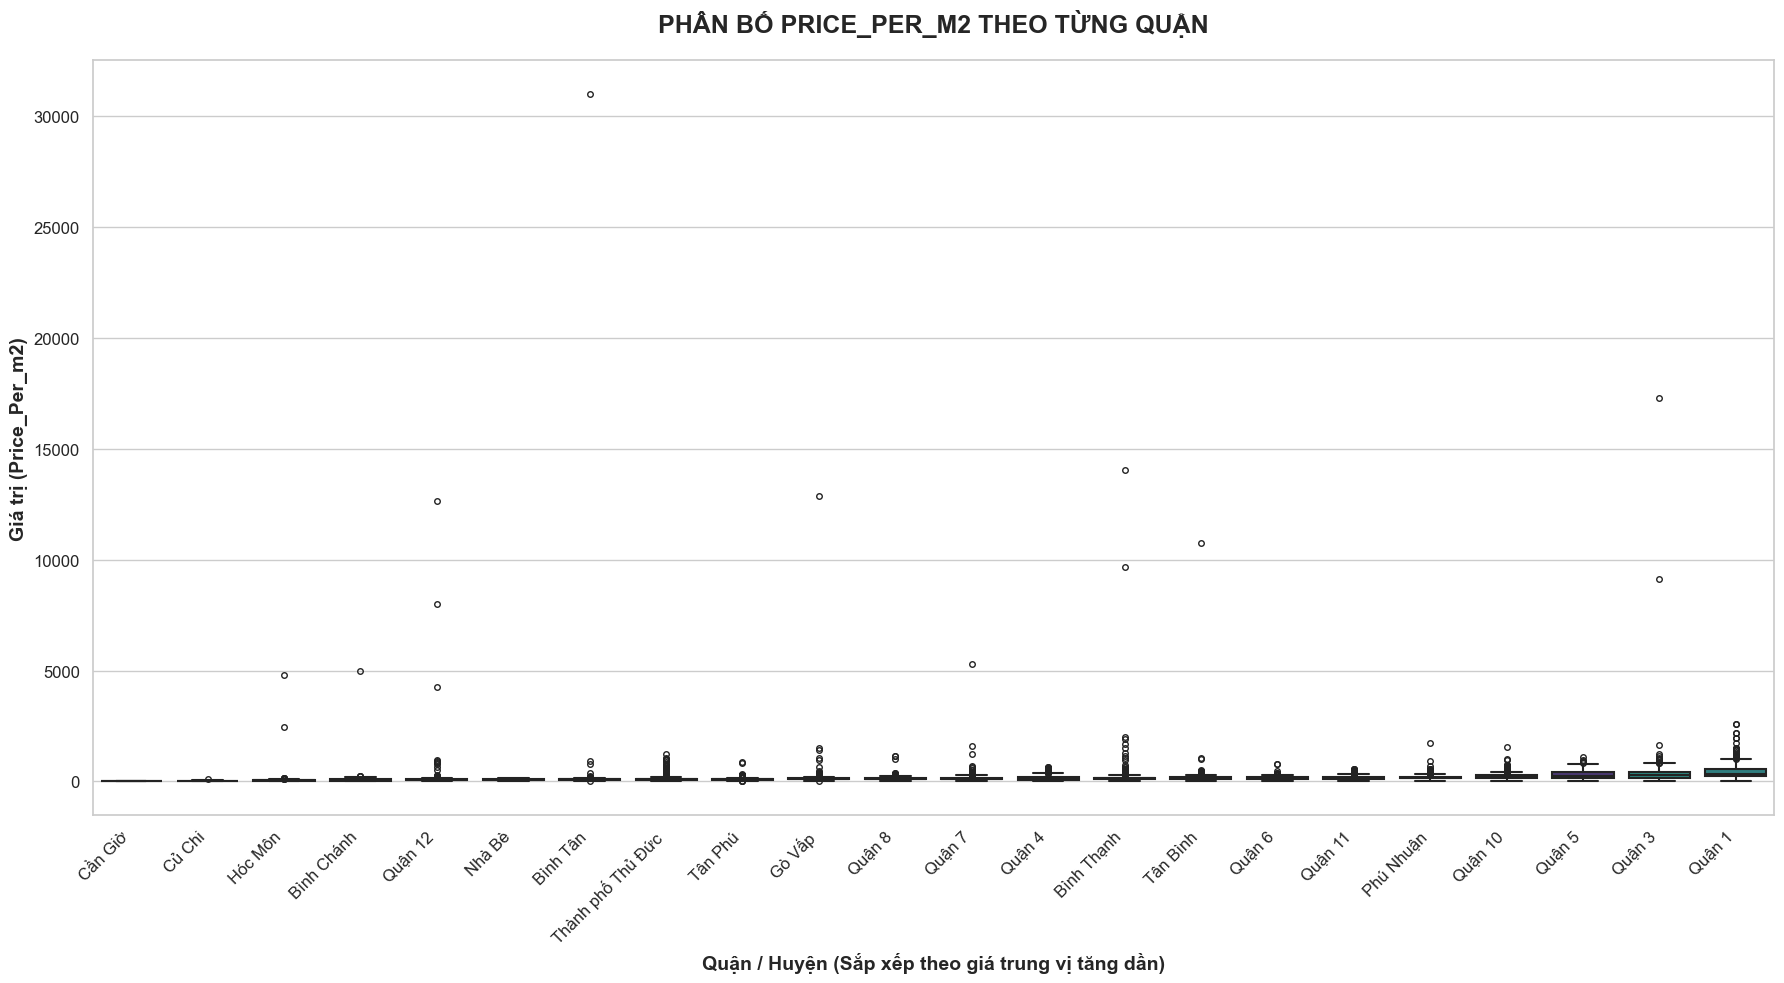

In [207]:
# Cấu hình đường dẫn
FILE_PATH = '../../data/cleaned/Done-p3-clean-logic.csv'
OUTPUT_IMG = '../../reports/boxplot_price_per_m2_check_after.png'


def plot_boxplot():
    # Kiểm tra và tự động tạo thư mục reports nếu chưa có
    output_dir = os.path.dirname(OUTPUT_IMG)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Đã tạo thư mục: {output_dir}")

    if not os.path.exists(FILE_PATH):
        print(f"File not found: {FILE_PATH}")
        return

    try:
        # Read Data
        df = pd.read_csv(FILE_PATH)

        # 1. Identify District Column
        col_dist = next((c for c in df.columns if any(k in c.lower() for k in ['district', 'quan', 'quận'])), None)

        # 2. Identify Price Column
        col_price = next((c for c in df.columns if 'price_per' in c.lower() or ('gia' in c.lower() and 'm2' in c.lower())), None)
        if not col_price:
            col_price = next((c for c in df.columns if 'price_billion' in c.lower() or 'price_ty' in c.lower()), None)

        if not col_dist or not col_price:
            print(f"Could not identify columns.")
            return

        print(f"Đang vẽ biểu đồ: {col_price} theo {col_dist}")

        # Preprocessing: Chuyển đổi số và lọc bỏ giá trị vô lý (<= 0)
        df[col_price] = pd.to_numeric(df[col_price], errors='coerce')
        df = df[df[col_price] > 0].dropna(subset=[col_price, col_dist])

        # Sắp xếp thứ tự Quận theo giá trung vị (Median)
        sorted_index = df.groupby(col_dist)[col_price].median().sort_values().index

        # --- SETUP PLOT ---
        sns.set_theme(style="whitegrid") # Set nền trắng có lưới cho chuyên nghiệp
        plt.figure(figsize=(18, 10))

        # Vẽ Boxplot: Thêm hue và palette
        sns.boxplot(
            x=col_dist,
            y=col_price,
            data=df,
            order=sorted_index,
            hue=col_dist,        # Sửa lỗi hue ở đây
            palette="viridis",   # Màu sắc sang trọng hơn
            legend=False,        # Tắt legend vì trục X đã có tên quận
            fliersize=4,         # Kích thước điểm ngoại lai
            linewidth=1.5
        )

        # Tùy chỉnh trục X và Y
        plt.xticks(rotation=45, ha='right', fontsize=12)
        plt.yticks(fontsize=12)

        # Tiêu đề và nhãn
        plt.title(f'PHÂN BỐ {col_price.upper()} THEO TỪNG QUẬN', fontsize=18, fontweight='bold', pad=20)
        plt.ylabel(f'Giá trị ({col_price})', fontsize=14, fontweight='bold')
        plt.xlabel('Quận / Huyện (Sắp xếp theo giá trung vị tăng dần)', fontsize=14, fontweight='bold')

        # Tự động điều chỉnh layout để không bị mất chữ
        plt.tight_layout()

        # Save với chất lượng cao (dpi=300) để dán vào PPT cực nét
        plt.savefig(OUTPUT_IMG, dpi=300)
        print(f"✅ Boxplot đã được lưu thành công tại: {OUTPUT_IMG}")

    except Exception as e:
        print(f"❌ Error: {e}")

if __name__ == "__main__":
    plot_boxplot()

Sau khi phân thích ta thấy xuất hiện quá nhiều ngoại lai giá trên trời

Tại sao lại dùng phương pháp IQR?

Cơ chế:
Nó tập trung vào 50% dữ liệu ở giữa (từ Q1 - 25% đến Q3 - 75%). Đây là vùng giá trị đại diện cho thị trường "thật"
.Khoảng cách $IQR = Q3 - Q1$.Bất kỳ giá trị nào vượt quá $1.5 \times IQR$ so với vùng giữa này được coi là bất thường
(quá rẻ hoặc quá đắt một cách vô lý so với mặt bằng chung).
Lợi ích: Nó loại bỏ các giá trị gây nhiễu (noise) mà không cần bạn phải đoán mò con số cụ thể (ví dụ: không cần quy định cứng "trên 100 tỷ là xóa").

Tại sao phải gom nhóm theo Quận (groupby('District'))?

- Tính địa phương (Locality): Giá bất động sản phụ thuộc cực lớn vào vị trí.

    Ví dụ: Đơn giá 500 triệu/m2 là bình thường ở Quận 1 (Trung tâm), nhưng là phi lý/ngoại lai ở Huyện Củ Chi (Ngoại ô).

- Nếu không gom nhóm (Global Filtering): Nếu bạn áp dụng IQR cho toàn bộ TP.HCM chung một lúc, thuật toán sẽ coi tất cả nhà ở Quận 1 là ngoại lai (vì giá cao hơn hẳn trung bình thành phố) và xóa sạch dữ liệu "xịn" này.

- Giải pháp trong code: Dòng group_df = df[df[group_col] == dist] đảm bảo rằng việc xét "đắt hay rẻ" được so sánh cục bộ trong chính quận đó. Nhà Quận 1 so với nhà Quận 1, nhà Củ Chi so với nhà Củ Chi.

Tại sao lọc trên Price_Per_m2 chứ không phải Price_Billion?

- Chuẩn hóa: Tổng giá (Price_Billion) chịu ảnh hưởng bởi Diện tích. Một căn biệt thự 1000m2 giá 200 tỷ là hợp lý. Nhưng một căn nhà 50m2 giá 200 tỷ là vô lý.

- Phản ánh đúng bản chất: Trong định giá bất động sản, đơn giá/m2 là thước đo chuẩn xác nhất để đánh giá phân khúc và phát hiện bất thường.

In [208]:
INPUT_FILE = '../../data/cleaned/Done-p3-clean-logic.csv'
OUTPUT_FILE = '../../data/cleaned/Done-EDA.csv'

def remove_outliers_iqr_by_group(df, group_col, value_col):
    """
    Lọc ngoại lai theo phương pháp IQR cho từng nhóm (Quận)
    """
    df_cleaned = pd.DataFrame()

    # Lấy danh sách các quận
    districts = df[group_col].unique()

    print(f"Bắt đầu lọc ngoại lai cho {len(districts)} khu vực dựa trên {value_col}...")

    for dist in districts:
        # Lấy dữ liệu của từng quận
        group_df = df[df[group_col] == dist].copy()

        # Bỏ qua nếu dữ liệu quận quá ít để tính toán thống kê
        if len(group_df) < 10:
            df_cleaned = pd.concat([df_cleaned, group_df])
            continue

        Q1 = group_df[value_col].quantile(0.25)
        Q3 = group_df[value_col].quantile(0.75)
        IQR = Q3 - Q1

        # Xác định biên (nới lỏng 1.5 hoặc chặt hơn là 1.0 tùy bạn)
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Lọc dữ liệu trong biên
        valid_rows = group_df[(group_df[value_col] >= lower_bound) & (group_df[value_col] <= upper_bound)]
        df_cleaned = pd.concat([df_cleaned, valid_rows])

    return df_cleaned

def main():
    try:
        df = pd.read_csv(INPUT_FILE)

        # 1. Chuyển đổi kiểu dữ liệu
        # Ưu tiên dùng Price_Per_m2 để lọc sẽ chuẩn hơn Price_Billion
        col_price_m2 = 'Price_Per_m2'
        col_district = 'District'

        # Đảm bảo dữ liệu số
        df[col_price_m2] = pd.to_numeric(df[col_price_m2], errors='coerce')
        df = df.dropna(subset=[col_price_m2, col_district])

        initial_count = len(df)

        # 2. Thực hiện lọc
        df_final = remove_outliers_iqr_by_group(df, col_district, col_price_m2)

        filtered_count = len(df_final)
        dropped_count = initial_count - filtered_count

        print("-" * 30)
        print(f"Tổng số dòng ban đầu: {initial_count}")
        print(f"Số dòng sau khi lọc IQR theo quận: {filtered_count}")
        print(f"Đã loại bỏ: {dropped_count} dòng ngoại lai")

        # 3. Lưu file
        df_final.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')
        print(f"Đã lưu file sạch tại: {OUTPUT_FILE}")

    except Exception as e:
        print(f"Lỗi: {e}")

if __name__ == "__main__":
    main()

Bắt đầu lọc ngoại lai cho 22 khu vực dựa trên Price_Per_m2...
------------------------------
Tổng số dòng ban đầu: 19963
Số dòng sau khi lọc IQR theo quận: 19111
Đã loại bỏ: 852 dòng ngoại lai
Đã lưu file sạch tại: ../../data/cleaned/Done-EDA.csv


Biểu đồ đã IQR

Đang vẽ biểu đồ: Price_Per_m2 theo District
✅ Boxplot đã được lưu thành công tại: ../../reports/boxplot_price_per_m2_check_after_IQR.png


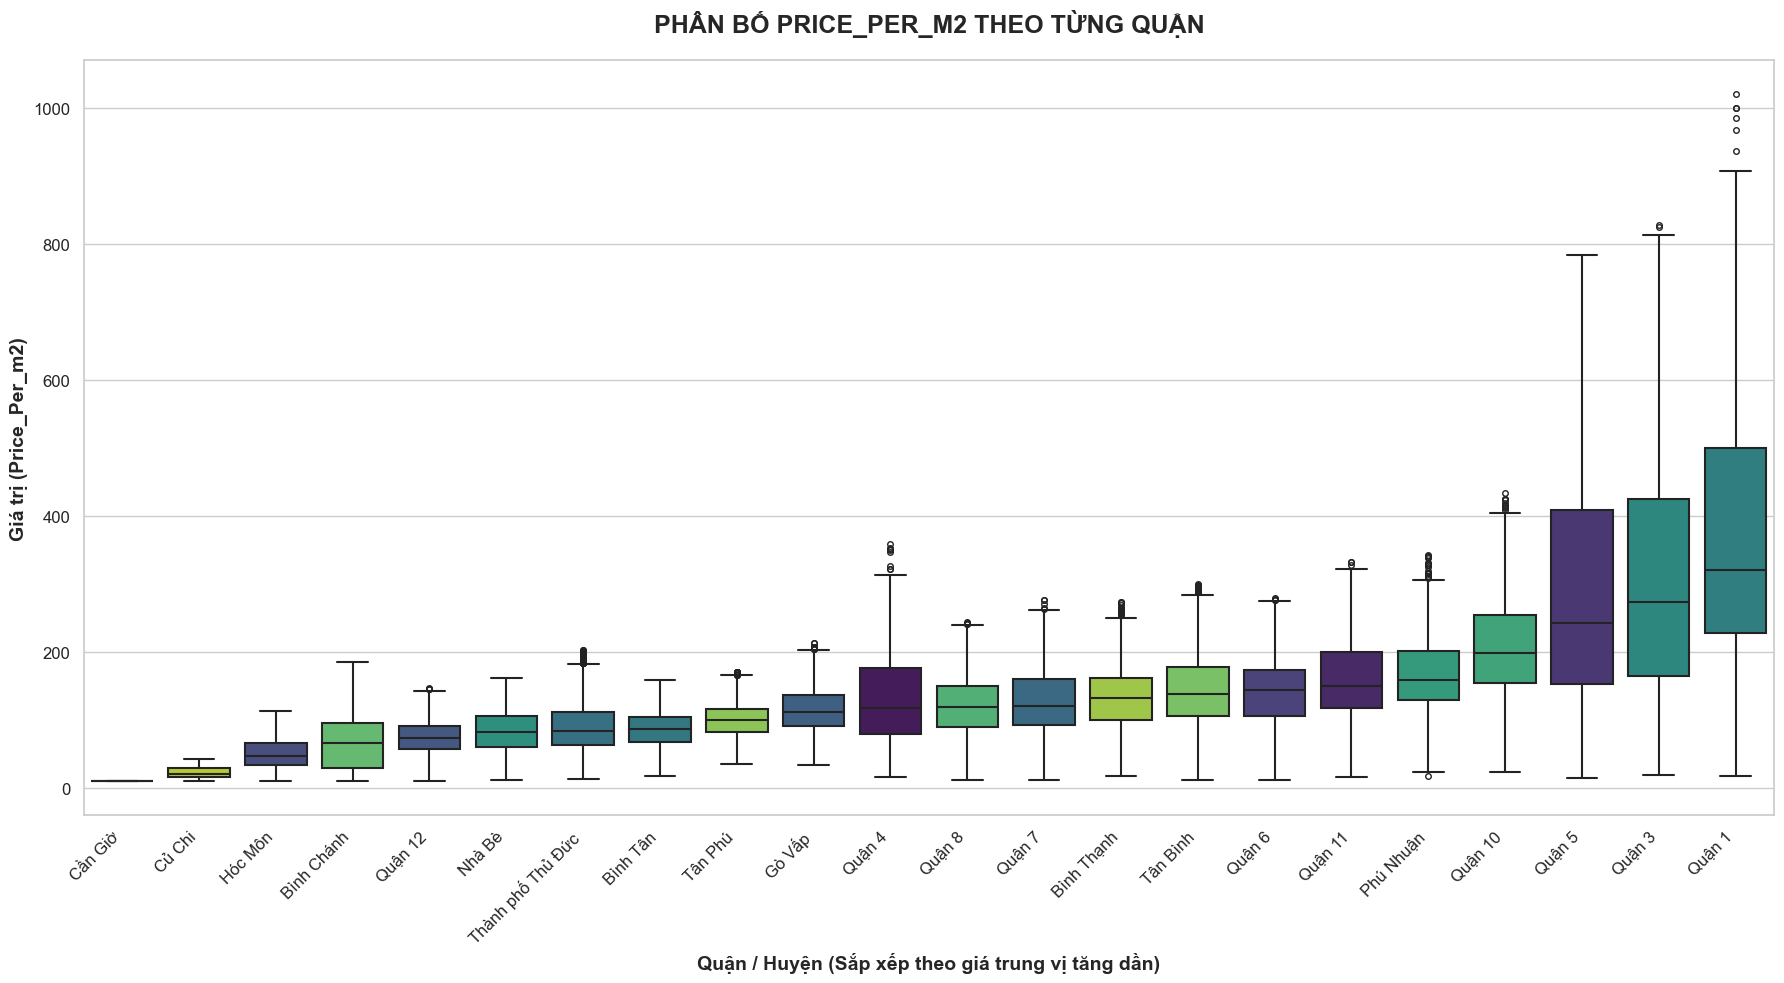

In [209]:
# File Path
FILE_PATH = '../../data/cleaned/Done-EDA.csv'
OUTPUT_IMG = '../../reports/boxplot_price_per_m2_check_after_IQR.png'

def plot_boxplot():
    # Kiểm tra và tự động tạo thư mục reports nếu chưa có
    output_dir = os.path.dirname(OUTPUT_IMG)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Đã tạo thư mục: {output_dir}")

    if not os.path.exists(FILE_PATH):
        print(f"File not found: {FILE_PATH}")
        return

    try:
        # Read Data
        df = pd.read_csv(FILE_PATH)

        # 1. Identify District Column
        col_dist = next((c for c in df.columns if any(k in c.lower() for k in ['district', 'quan', 'quận'])), None)

        # 2. Identify Price Column
        col_price = next((c for c in df.columns if 'price_per' in c.lower() or ('gia' in c.lower() and 'm2' in c.lower())), None)
        if not col_price:
            col_price = next((c for c in df.columns if 'price_billion' in c.lower() or 'price_ty' in c.lower()), None)

        if not col_dist or not col_price:
            print(f"Could not identify columns.")
            return

        print(f"Đang vẽ biểu đồ: {col_price} theo {col_dist}")

        # Preprocessing: Chuyển đổi số và lọc bỏ giá trị vô lý (<= 0)
        df[col_price] = pd.to_numeric(df[col_price], errors='coerce')
        df = df[df[col_price] > 0].dropna(subset=[col_price, col_dist])

        # Sắp xếp thứ tự Quận theo giá trung vị (Median)
        sorted_index = df.groupby(col_dist)[col_price].median().sort_values().index

        # --- SETUP PLOT ---
        sns.set_theme(style="whitegrid") # Set nền trắng có lưới cho chuyên nghiệp
        plt.figure(figsize=(18, 10))

        # Vẽ Boxplot: Thêm hue và palette
        sns.boxplot(
            x=col_dist,
            y=col_price,
            data=df,
            order=sorted_index,
            hue=col_dist,        # Sửa lỗi hue ở đây
            palette="viridis",   # Màu sắc sang trọng hơn
            legend=False,        # Tắt legend vì trục X đã có tên quận
            fliersize=4,         # Kích thước điểm ngoại lai
            linewidth=1.5
        )

        # Tùy chỉnh trục X và Y
        plt.xticks(rotation=45, ha='right', fontsize=12)
        plt.yticks(fontsize=12)

        # Tiêu đề và nhãn
        plt.title(f'PHÂN BỐ {col_price.upper()} THEO TỪNG QUẬN', fontsize=18, fontweight='bold', pad=20)
        plt.ylabel(f'Giá trị ({col_price})', fontsize=14, fontweight='bold')
        plt.xlabel('Quận / Huyện (Sắp xếp theo giá trung vị tăng dần)', fontsize=14, fontweight='bold')

        # Tự động điều chỉnh layout để không bị mất chữ
        plt.tight_layout()

        # Save với chất lượng cao (dpi=300) để dán vào PPT cực nét
        plt.savefig(OUTPUT_IMG, dpi=300)
        print(f"✅ Boxplot đã được lưu thành công tại: {OUTPUT_IMG}")

    except Exception as e:
        print(f"❌ Error: {e}")

if __name__ == "__main__":
    plot_boxplot()

9. Kiểm tra lại data

In [227]:

def inspect_csv(df):
    print("===== CSV OVERVIEW =====")
    print(f"Rows    : {df.shape[0]}")
    print(f"Columns : {df.shape[1]}")
    print("\n--- Data types ---")
    print(df.dtypes)
    print("\n--- Memory usage ---")
    print(round(df.memory_usage(deep=True).sum() / 1024 ** 2, 2), "MB")


df_raw = pd.read_csv("../../data/cleaned/Done-EDA.csv")
inspect_csv(df_raw)

===== CSV OVERVIEW =====
Rows    : 19111
Columns : 12

--- Data types ---
Price_Billion    float64
Price_Per_m2     float64
Area_m2          float64
District          object
Ward              object
Bedrooms         float64
Is_MatTien         int64
Width_m          float64
Floors           float64
Is Hem             int64
Post Time         object
Toilets          float64
dtype: object

--- Memory usage ---
5.08 MB


Kiểm tra ô thiếu

In [211]:
def report_missing_values(df):
    print("===== MISSING VALUE REPORT =====")
    missing = df.isna().sum()
    percent = (missing / len(df)) * 100
    report = pd.DataFrame({
        "Missing_Count": missing,
        "Percent_Missing (%)": percent.round(2)
    }).sort_values(by="Missing_Count", ascending=False)
    print(report)
    return report


In [212]:
report_missing_values(df_raw)

===== MISSING VALUE REPORT =====
               Missing_Count  Percent_Missing (%)
Width_m                    1                 0.01
Price_Billion              0                 0.00
Area_m2                    0                 0.00
Price_Per_m2               0                 0.00
District                   0                 0.00
Ward                       0                 0.00
Bedrooms                   0                 0.00
Is_MatTien                 0                 0.00
Floors                     0                 0.00
Is Hem                     0                 0.00
Post Time                  0                 0.00
Toilets                    0                 0.00


,Missing_Count,Percent_Missing (%)
Width_m,1,0.01
Price_Billion,0,0.00
Area_m2,0,0.00
Price_Per_m2,0,0.00
District,0,0.00
Ward,0,0.00
Bedrooms,0,0.00
Is_MatTien,0,0.00
Floors,0,0.00
Is Hem,0,0.00


In [213]:
df_raw.head()

,Price_Billion,Price_Per_m2,Area_m2,District,Ward,Bedrooms,Is_MatTien,Width_m,Floors,Is Hem,Post Time,Toilets
0,3.99,88.67,45.0,Quận 4,8,3.0,1,4.5,1.0,0,4/1/2026,3.0
1,1.80,50.00,36.0,Quận 4,4,3.0,1,4.0,1.0,0,31/12/2025,3.0
2,3.15,70.00,45.0,Quận 4,15,3.0,1,4.0,3.5,0,30/12/2025,3.0
3,22.00,79.42,277.0,Quận 4,16,6.0,0,9.0,7.0,1,30/12/2025,6.0
4,3.80,171.17,22.2,Quận 4,13,1.0,0,3.0,2.0,1,30/12/2025,1.0


Nhận xét

    Dataset đã được gộp từ nhiều nguồn và load thành công.
    Dữ liệu ở dạng bảng, mỗi dòng là một bất động sản.

In [214]:
print("Rows:", df_raw.shape[0])
print("Columns:", df_raw.shape[1])

df_raw.info()


Rows: 19111
Columns: 12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19111 entries, 0 to 19110
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Price_Billion  19111 non-null  float64
 1   Price_Per_m2   19111 non-null  float64
 2   Area_m2        19111 non-null  float64
 3   District       19111 non-null  object 
 4   Ward           19111 non-null  object 
 5   Bedrooms       19111 non-null  float64
 6   Is_MatTien     19111 non-null  int64  
 7   Width_m        19110 non-null  float64
 8   Floors         19111 non-null  float64
 9   Is Hem         19111 non-null  int64  
 10  Post Time      19111 non-null  object 
 11  Toilets        19111 non-null  float64
dtypes: float64(7), int64(2), object(3)
memory usage: 1.7+ MB


Nhận xét

    Dataset gồm 19,105 dòng và 12 cột.
    Bao gồm cả biến số (giá, diện tích) và biến phân loại (quận, mặt tiền, hẻm).
    Phù hợp cho bài toán phân tích và phân loại giá nhà đất.

    Price_Billion   : Giá nhà (tỷ VNĐ)
    Price_Per_m2    : Giá trên mỗi mét vuông
    Area_m2         : Diện tích nhà
    District        : Quận
    Ward            : Phường
    Bedrooms        : Số phòng ngủ
    Toilets         : Số toilet
    Floors          : Số tầng
    Width_m         : Chiều ngang nhà
    Is_MatTien      : 1 = nhà mặt tiền, 0 = không
    Is_Hem          : 1 = nhà trong hẻm, 0 = không
    Post Time       : Thời gian đăng bài
    Segment         : Phân khúc giá nhà

10. tạo feature Segment phân khúc giá nhà

In [237]:
# 1. Load dữ liệu
df = pd.read_csv("../../data/cleaned/Done-EDA.csv")
df_ref = pd.read_csv("../../data/cleaned/Bench.csv")

# 2. Tiền xử lý file Benchmark: Loại bỏ 'nha_o' để tránh trùng lặp logic
# Chỉ giữ lại nha_mat_pho (0,1) và nha_ngõ_hẻm (1,0)
df_ref_clean = df_ref[df_ref['type_house'] != 'nha_o'].copy()

# 3. Thực hiện Merge (So sánh 3 cột: Quận, Hẻm, Mặt tiền)
df_final = df.merge(
    df_ref_clean[['district', 'is_hem', 'is_mattien', 'price_per_m2_avg', 'price_per_m2_low_avg', 'price_per_m2_high_avg']],
    left_on=['District', 'Is Hem', 'Is_MatTien'],
    right_on=['district', 'is_hem', 'is_mattien'],
    how='left'
)

# Kiểm tra số dòng sau merge (Phải bằng đúng số dòng ban đầu của df)
print(f"Số dòng file gốc: {len(df)}")
print(f"Số dòng sau khi so sánh đối chiếu: {len(df_final)}")

Số dòng file gốc: 19111
Số dòng sau khi so sánh đối chiếu: 19111


Phân loại Segment chuyên sâu

In [238]:
def create_segment(row):
    p = row['Price_Per_m2']
    avg = row['price_per_m2_avg']
    low = row['price_per_m2_low_avg']
    high = row['price_per_m2_high_avg']

    # Nếu không khớp được giá chuẩn từ Bench, gán mặc định Trung cấp
    if pd.isna(avg):
        return "Trung cấp"

    if p <= low:
        return 'Bình dân'
    elif p <= avg:
        return 'Trung cấp'
    elif p <= high:
        return 'Cao cấp'
    else:
        return 'VIP'

df_final['Segment'] = df_final.apply(create_segment, axis=1)
df_final['Segment'] = pd.Categorical(df_final['Segment'],
                                   categories=['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP'],
                                   ordered=True)

# Xóa các cột thừa sau khi đã tính xong Segment để file gọn hơn
df_final = df_final.drop(columns=['district', 'price_per_m2_avg','is_hem','is_mattien', 'price_per_m2_low_avg', 'price_per_m2_high_avg'])

print("Thống kê phân khúc nhà đất:")
print(df_final['Segment'].value_counts())

Thống kê phân khúc nhà đất:
Segment
Trung cấp    10426
Bình dân      4281
Cao cấp       3309
VIP           1095
Name: count, dtype: int64


Tỷ lệ phân bổ phân khúc (%) giữa Nhà Hẻm (0) và Mặt Tiền (1):
Segment     Bình dân  Trung cấp  Cao cấp   VIP
Is_MatTien                                    
0              14.84      59.31    17.59  8.26
1              34.07      47.22    16.89  1.82


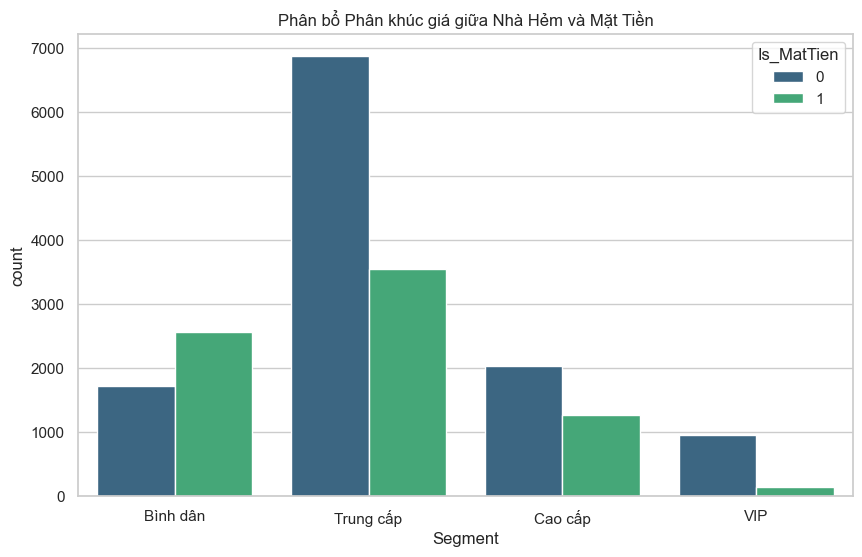

In [239]:
# Tính tỷ lệ phần trăm phân khúc theo từng loại nhà (Hẻm vs Mặt tiền)
insight = pd.crosstab(df_final['Is_MatTien'], df_final['Segment'], normalize='index') * 100
print("Tỷ lệ phân bổ phân khúc (%) giữa Nhà Hẻm (0) và Mặt Tiền (1):")
print(insight.round(2))

# Vẽ biểu đồ trực quan để lấy ảnh dán vào PPT
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(data=df_final, x='Segment', hue='Is_MatTien', palette='viridis')
plt.title('Phân bổ Phân khúc giá giữa Nhà Hẻm và Mặt Tiền')
plt.show()

In [240]:
df_final.head()

,Price_Billion,Price_Per_m2,Area_m2,District,Ward,Bedrooms,Is_MatTien,Width_m,Floors,Is Hem,Post Time,Toilets,Segment
0,3.99,88.67,45.0,Quận 4,8,3.0,1,4.5,1.0,0,4/1/2026,3.0,Bình dân
1,1.80,50.00,36.0,Quận 4,4,3.0,1,4.0,1.0,0,31/12/2025,3.0,Bình dân
2,3.15,70.00,45.0,Quận 4,15,3.0,1,4.0,3.5,0,30/12/2025,3.0,Bình dân
3,22.00,79.42,277.0,Quận 4,16,6.0,0,9.0,7.0,1,30/12/2025,6.0,Bình dân
4,3.80,171.17,22.2,Quận 4,13,1.0,0,3.0,2.0,1,30/12/2025,1.0,Cao cấp


1. Tại sao cần thiết lập thuộc tính Segment?Việc sử dụng cột Segment không đơn thuần là phân loại giá, mà là một bước Feature Engineering (Kỹ thuật đặc trưng) quan trọng nhằm giải quyết các vấn đề sau:Chuẩn hóa giá trị theo địa phương (Location-based Normalization): Giá bất động sản bị chi phối mạnh mẽ bởi vị trí. Một căn nhà 100 triệu/m2 có thể là "Bình dân" tại Quận 1 nhưng lại là "VIP" tại huyện Bình Chánh. Thuộc tính Segment giúp mô hình máy học hiểu được giá trị tương đối của bất động sản trong ngữ cảnh của khu vực đó thay vì chỉ nhìn vào con số tuyệt đối.Giảm thiểu nhiễu dữ liệu (Noise Reduction): Thị trường bất động sản luôn có những tin đăng ảo hoặc các trường hợp đặc biệt. Bằng cách đối chiếu với khung giá Benchmark (Low - Avg - High), chúng ta xác định được vị thế thực sự của tài sản, giúp mô hình phân biệt được đâu là nhà giá rẻ thực sự và đâu là bất động sản cao cấp.Tăng khả năng phân tách dữ liệu (Linear Separability): Trong các mô hình dự báo, việc có thêm các nhãn phân khúc giúp thuật toán dễ dàng nhận diện các nhóm dữ liệu có đặc tính giống nhau, từ đó cải thiện độ chính xác ($R^2$ score) khi huấn luyện.
2. Logic trích xuất Insight từ dữ liệu
Dựa trên quy trình so sánh đối chiếu (Mapping) giữa thuộc tính Is_Hem/Is_MatTien với file Benchmark, chúng ta thu được các nhận định sau:

Tương quan giữa Vị trí và Phân khúc:

Nhà Hẻm (Alley): Thường tập trung ở phân khúc Bình dân và Trung cấp. Nếu một bất động sản trong hẻm rơi vào nhóm VIP, đây là biến số quan trọng chỉ ra đó là hẻm xe hơi, hẻm thương mại hoặc có diện tích đặc biệt lớn.

Nhà Mặt tiền (Street-front): Chiếm tỷ trọng áp đảo trong nhóm Cao cấp và VIP. Những căn mặt tiền nằm ở phân khúc thấp là dấu hiệu của "bất thường" cần kiểm tra (nhà nát, diện tích quá nhỏ, hoặc lỗi pháp lý).

Cơ cấu thị trường: Tỷ lệ phần trăm giữa các phân khúc (ví dụ: Trung cấp chiếm đa số) phản ánh tính thanh khoản của thị trường. Một thị trường bền vững thường có hình kim tự tháp với phân khúc Trung cấp và Bình dân làm nền tảng.
3. Kết luận cho báo cáo tiền xử lý
"Việc tích hợp dữ liệu Benchmark để hình thành cột Segment giúp bộ dữ liệu không chỉ dừng lại ở các thông số kỹ thuật (diện tích, số tầng) mà còn mang thêm giá trị thị trường. Đây là cơ sở dữ liệu 'sạch' và 'giàu ngữ cảnh', cho phép các mô hình dự báo sau này đạt được độ tin cậy cao hơn khi phản ánh đúng thực tế biến động giá theo từng loại hình nhà ở và từng đơn vị hành chính cụ thể."

In [241]:
df_final.to_csv("../../data/cleaned/Final.csv",encoding='utf-8-sig', index=False)

In [242]:
def inspect_csv(df):
    print("===== CSV OVERVIEW =====")
    print(f"Rows    : {df.shape[0]}")
    print(f"Columns : {df.shape[1]}")
    print("\n--- Data types ---")
    print(df.dtypes)
    print("\n--- Memory usage ---")
    print(round(df.memory_usage(deep=True).sum() / 1024 ** 2, 2), "MB")


df_raw = pd.read_csv("../../data/cleaned/Final.csv")
inspect_csv(df_raw)


def report_missing_values(df):
    print("===== MISSING VALUE REPORT =====")
    missing = df.isna().sum()
    percent = (missing / len(df)) * 100
    report = pd.DataFrame({
        "Missing_Count": missing,
        "Percent_Missing (%)": percent.round(2)
    }).sort_values(by="Missing_Count", ascending=False)
    print(report)
    return report


===== CSV OVERVIEW =====
Rows    : 19111
Columns : 13

--- Data types ---
Price_Billion    float64
Price_Per_m2     float64
Area_m2          float64
District          object
Ward              object
Bedrooms         float64
Is_MatTien         int64
Width_m          float64
Floors           float64
Is Hem             int64
Post Time         object
Toilets          float64
Segment           object
dtype: object

--- Memory usage ---
6.52 MB


In [243]:
report_missing_values(df_raw)
df_raw.head()

print("Rows:", df_raw.shape[0])
print("Columns:", df_raw.shape[1])

===== MISSING VALUE REPORT =====
               Missing_Count  Percent_Missing (%)
Width_m                    1                 0.01
Price_Per_m2               0                 0.00
Area_m2                    0                 0.00
District                   0                 0.00
Price_Billion              0                 0.00
Ward                       0                 0.00
Bedrooms                   0                 0.00
Is_MatTien                 0                 0.00
Floors                     0                 0.00
Is Hem                     0                 0.00
Post Time                  0                 0.00
Toilets                    0                 0.00
Segment                    0                 0.00
Rows: 19111
Columns: 13


In [245]:
df_raw.drop(columns="Ward")

,Price_Billion,Price_Per_m2,Area_m2,District,Bedrooms,Is_MatTien,Width_m,Floors,Is Hem,Post Time,Toilets,Segment
0,3.99,88.67,45.0,Quận 4,3.0,1,4.5,1.0,0,4/1/2026,3.0,Bình dân
1,1.80,50.00,36.0,Quận 4,3.0,1,4.0,1.0,0,31/12/2025,3.0,Bình dân
2,3.15,70.00,45.0,Quận 4,3.0,1,4.0,3.5,0,30/12/2025,3.0,Bình dân
3,22.00,79.42,277.0,Quận 4,6.0,0,9.0,7.0,1,30/12/2025,6.0,Bình dân
4,3.80,171.17,22.2,Quận 4,1.0,0,3.0,2.0,1,30/12/2025,1.0,Cao cấp
...,...,...,...,...,...,...,...,...,...,...,...,...
19106,12.00,14.67,818.0,Củ Chi,2.0,1,14.5,1.0,0,23/05/2025,1.0,Trung cấp
19107,3.95,10.70,369.0,Củ Chi,1.0,1,30.0,1.0,0,7/5/2025,2.0,Trung cấp
19108,16.00,38.83,412.0,Củ Chi,5.0,1,16.5,1.0,0,9/4/2025,6.0,Trung cấp
19109,6.00,10.17,590.0,Củ Chi,2.0,1,5.0,1.0,0,25/04/2025,2.0,Trung cấp


In [246]:
df_raw.to_csv("../../data/cleaned/Final_without_ward.csv",encoding='utf-8-sig', index=False)

One-Hot Encoding cho các biến phân loại (District)

In [247]:
# 1. Load dữ liệu đã dọn dẹp (đã bỏ Phường)
df = pd.read_csv("../../data/cleaned/Final_without_ward.csv", encoding='utf-8-sig')

# 2. Thực hiện One-Hot Encoding cho cột District
# prefix='Dist' giúp dễ nhận diện các cột mới sinh ra
# drop_first=True để tránh bẫy đa cộng tuyến (Dummy Variable Trap) trong thống kê
df_encoded = pd.get_dummies(df, columns=['District'], prefix='Dist', drop_first=True)

print(f"Số lượng cột sau khi Encoding: {df_encoded.shape[1]}")
print("Các cột mới tạo ra:", [c for c in df_encoded.columns if c.startswith('Dist_')][:5], "...")

Số lượng cột sau khi Encoding: 33
Các cột mới tạo ra: ['Dist_Bình Thạnh', 'Dist_Bình Tân', 'Dist_Cần Giờ', 'Dist_Củ Chi', 'Dist_Gò Vấp'] ...


Insight chuyên nghiệp: Việc sử dụng drop_first=True là một kỹ thuật quan trọng. Nếu có $n$ quận, chúng ta chỉ cần $n-1$ cột để biểu diễn. Nếu tất cả $n-1$ cột đều bằng 0, máy tính tự hiểu căn nhà nằm ở quận cuối cùng. Điều này giúp loại bỏ sự dư thừa thông tin và giúp các mô hình như Linear Regression hoạt động ổn định hơn.

Ordinal Encoding cho biến Segment

In [248]:
from sklearn.preprocessing import OrdinalEncoder

# 1. Khởi tạo Encoder với thứ tự xác định
segment_order = [['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP']]
ord_encoder = OrdinalEncoder(categories=segment_order)

# 2. Áp dụng mã hóa
df_encoded['Segment_Encoded'] = ord_encoder.fit_transform(df_encoded[['Segment']])

# 3. Loại bỏ cột chữ 'Segment' cũ và các cột không dùng cho Model
df_final_features = df_encoded.drop(columns=['Segment', 'Post Time', 'Ward'], errors='ignore')

print("Thứ tự mã hóa Segment:", segment_order)

Thứ tự mã hóa Segment: [['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP']]


Insight chuyên nghiệp: Bằng cách mã hóa Bình dân = 0 và VIP = 3, chúng ta đang "nhắc" cho mô hình biết rằng giá trị của bất động sản tỷ lệ thuận với cấp bậc của phân khúc. Đây là thông tin cực kỳ đắt giá giúp tăng độ chính xác của dự báo mà không cần thêm quá nhiều dữ liệu.

In [250]:
from sklearn.preprocessing import StandardScaler
# 1. Xác định các cột số cần chuẩn hóa
num_cols = ['Area_m2', 'Width_m', 'Floors', 'Bedrooms', 'Toilets']

# 2. Khởi tạo StandardScaler
scaler = StandardScaler()

# 3. Tiến hành Scale
df_final_features[num_cols] = scaler.fit_transform(df_final_features[num_cols])

# 4. Lưu file sẵn sàng cho Machine Learning
df_final_features.to_csv("../../data/cleaned/Data_Ready_For_ML_Final.csv", encoding='utf-8-sig', index=False)

print("✅ Đã hoàn tất quy trình Preprocessing.")
print("Dữ liệu hiện tại đã là dạng số và được chuẩn hóa hoàn toàn.")

✅ Đã hoàn tất quy trình Preprocessing.
Dữ liệu hiện tại đã là dạng số và được chuẩn hóa hoàn toàn.


Ma trận tương quan

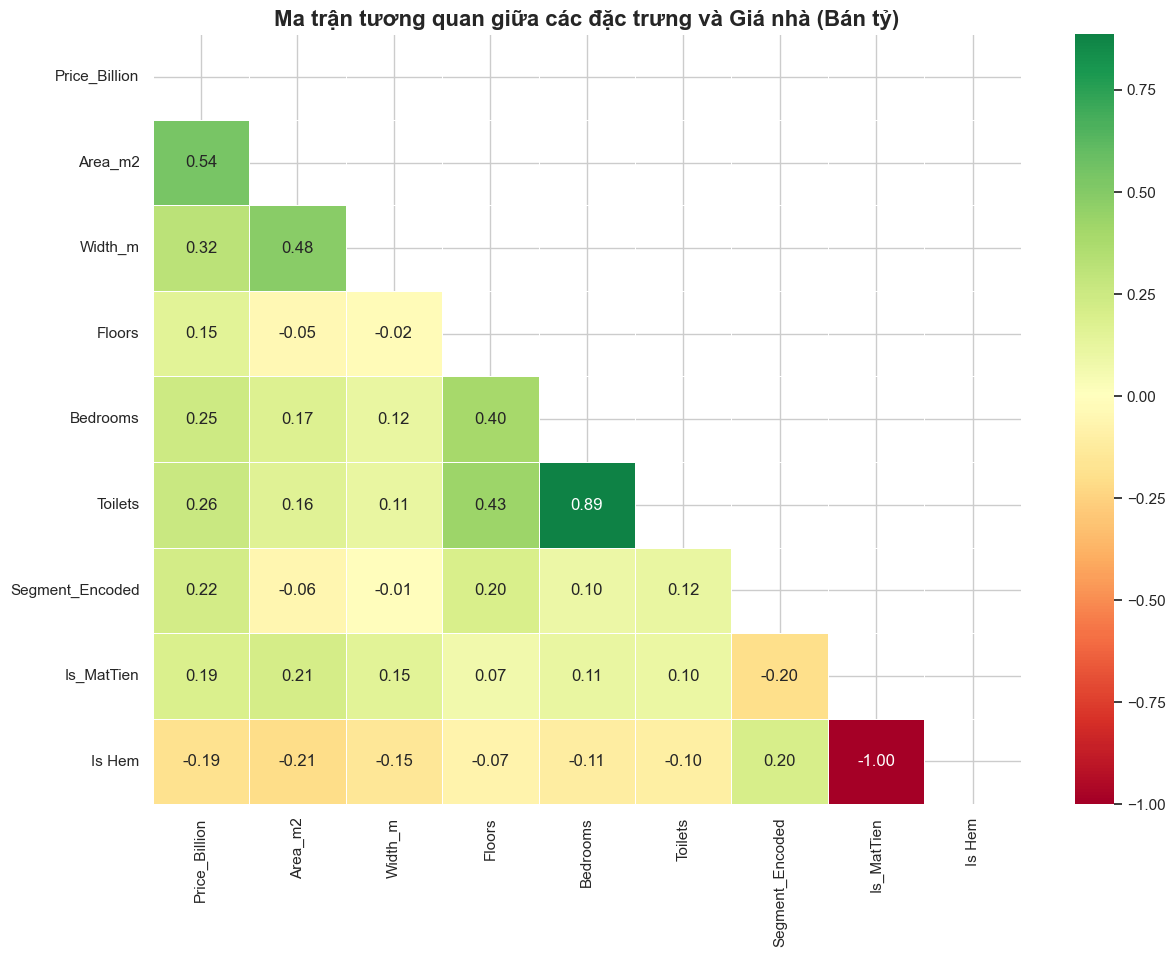

In [253]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Chọn các cột quan trọng để vẽ (tránh bị quá dày đặc)
# Bao gồm các cột số và các cột Encode quan trọng
main_features = ['Price_Billion', 'Area_m2', 'Width_m', 'Floors', 'Bedrooms', 'Toilets', 'Segment_Encoded', 'Is_MatTien', 'Is Hem']
# Thêm một vài cột Quận tiêu biểu để xem mức độ tương quan
dist_features = [col for col in df_final_features.columns if 'Dist_Quận_1' in col or 'Dist_Quận_3' in col or 'Dist_Quận_7' in col]
cols_to_plot = main_features + dist_features

# 2. Tính toán ma trận tương quan
corr_matrix = df_final_features[cols_to_plot].corr()

# 3. Vẽ Heatmap
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Chỉ vẽ một nửa để dễ nhìn

sns.heatmap(corr_matrix,
            mask=mask,
            annot=True,          # Hiển thị số
            fmt=".2f",           # Lấy 2 chữ số thập phân
            cmap='RdYlGn',       # Màu đỏ (âm) - Vàng - Xanh (dương)
            center=0,
            linewidths=.5)

plt.title('Ma trận tương quan giữa các đặc trưng và Giá nhà (Bán tỷ)', fontsize=16, fontweight='bold')
plt.show()

Tương quan Thuận (Màu Xanh/Số dương):

Area_m2 & Price_Billion: Thường có tương quan cao nhất (ví dụ > 0.6). Diện tích càng lớn, giá càng cao - đây là logic cơ bản.

Segment_Encoded & Price_Billion: Nếu con số này cao, nó chứng minh cột Segment bạn tạo ra từ file Bench cực kỳ có giá trị trong việc giải thích biến động giá.

Is_MatTien: Thường tương quan dương với giá (nhà mặt tiền giá cao hơn).

Tương quan Nghịch (Màu Đỏ/Số âm):

Is Hem: Thường mang giá trị âm khi so với Price_Billion, điều này hợp lý vì nhà hẻm thường có giá thấp hơn nhà mặt phố.

Hiện tượng Đa cộng tuyến (Multicollinearity):

Nếu Bedrooms và Toilets có tương quan quá cao (ví dụ > 0.9), bạn có thể nhận xét là chúng cung cấp thông tin tương tự nhau, giúp mô hình hiểu được quy mô của căn nhà.